In [26]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Basic word2vec example."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os,sys
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

import pickle

import pandas as pd
import numpy as np
import re

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import scipy
%matplotlib inline
import string

import matplotlib.pyplot as plt
import seaborn

In [4]:
embeddings = (pickle.load(open(os.getcwd()+"/Saved/embeddings.p", "rb")))
dictionary = pickle.load(open(os.getcwd()+"/Saved/dictionary.p", "rb"))
reverse_dictionary = pickle.load(open(os.getcwd()+"/Saved/reverse_dictionary.p", "rb"))

In [5]:
# verify that embedding makes sense
valid_size = 10     # Random set of words to evaluate similarity on.
valid_window = 1000  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

def close(index):
    word = embeddings[index,:]
    distance = np.dot(embeddings, word)
    rank = (-distance).argsort()
    close_list = ""
    for i in range(5):
        close_list += reverse_dictionary[rank[i]]
        close_list += " "
    return close_list
for index in valid_examples:
    print(close(index))

important interesting impressive influential arguably 
america carolina oceania dakota africa 
change biodiversity warming desertification changes 
actress playwright guitarist novelist comedian 
history chronology eugenics cinema archaeology 
mass kinetic intensity orbiting masses 
using iterative simulator extensible automated 
december february march january june 
best grammy worst bafta outstanding 
known remembered depicted hailed disguised 


In [62]:
df = pd.read_csv(os.getcwd()+"/train.tsv", sep='\t')

(741268, 8) (370633, 8) (370636, 8)


In [63]:
# create column of log price
# combine categories and item description into one variable, with 
# item description first, then brand name, and categories appended
# at the end
df['item_description'] = df['item_description'].astype(str)
df['brand_name'] = df['brand_name'].astype(str)
df['category_name'] = df['category_name'].astype(str)
df['log_price'] = np.log(df.price+1)
# gauge the appropriate max length of sequence to use
def des_len(text):
    tokens = re.sub(r'[^\w\s]','',text).lower()
    return tokens, len(tokens.split())
df['item_description'], df['desc_len'] = zip(*df['item_description'].apply(des_len))

In [66]:
# split into a train dataset and a test dataset, and a validation dataset
train = df.loc[0:len(df)//2,:]
test = df.loc[len(df)//2:len(df)//4*3, :]
validation = df.loc[len(df)//4*3:,:]
print(train.shape, test.shape, validation.shape)
cat_avg_price = train.groupby(['category_name', 'brand_name']).log_price.agg(['mean']).reset_index()
cat_avg_price = cat_avg_price.rename(columns={"mean": "cat_brand_avg_log_price"})

(741268, 10) (370633, 10) (370636, 10)


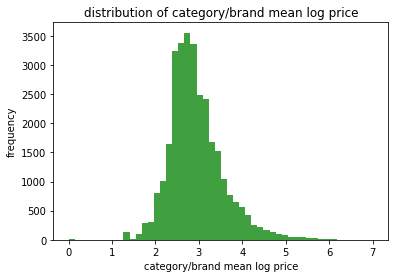

In [67]:
_ = plt.hist(cat_avg_price['cat_brand_avg_log_price'], 50, facecolor='green', alpha=0.75)
plt.ylabel('frequency')
plt.xlabel('category/brand mean log price')
plt.title('distribution of category/brand mean log price')
plt.show()
# there is evidence that average prices vary across categories
# so the item description can be used to model how a specific item differs 
# from the average item within the same category-brand combination
# and how that difference can be used to predict whether, and by how much, the price should be marked up or down

In [69]:
train = train.merge(cat_avg_price, on=['category_name', 'brand_name'])
train['markup'] = train.log_price - train.cat_brand_avg_log_price
test = test.merge(cat_avg_price, on=['category_name', 'brand_name'])
validation = validation.merge(cat_avg_price, on=['category_name', 'brand_name'])

# the goal of the exercise would be to predict the markup for each item, given its category name and item description

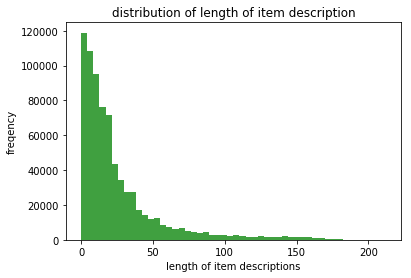

using max length of 200 captures  99.9991 percent of data
using max length of 50 captures  86.7652 percent of data
using max length of 25 captures  67.9051 percent of data


In [80]:
_ = plt.hist(train.desc_len, bins= 50, facecolor='green', alpha=0.75)
plt.xlabel('length of item descriptions')
plt.ylabel('freqency')
plt.title('distribution of length of item description')
plt.show()
# sequence length of 200 seems fine, capturing most of the lengths
print("using max length of 200 captures  %.4f percent of data" 
      % (train[train.desc_len<200].shape[0] / train.shape[0]*100))
# for computational reasons, limit to using max sequence length of 50
print("using max length of 50 captures  %.4f percent of data" 
      % (train[train.desc_len<50].shape[0] / train.shape[0]*100))
print("using max length of 25 captures  %.4f percent of data" 
      % (train[train.desc_len<25].shape[0] / train.shape[0]*100))

In [37]:
# create a numpy array holding the data
# shape of array is len(train) x 200 x 150, where 200 is the max length, and 150 is the dimensionality of the word embedding
# create a list of sequence length corresponding to the data
max_T = 50
embedding_size = embeddings[0].shape[0]
def pad(batch_size = 1000):
    global train_start_position
    reset_condition = False # whether to reset the index of batch starting point
    if train_start_position + batch_size > len(train):
        train_start_position = len(train) - batch_size
        print("at the end of training data; need to start from beginning")
        reset_condition = True
    X = np.zeros((batch_size, max_T, embedding_size), dtype=float)
    y = np.zeros((batch_size,), dtype=float)
    seq_length = np.zeros((batch_size,), dtype=int)
    
    row = 0
    for i in range(train_start_position, train_start_position + batch_size):
        tokens = train.loc[i,'item_description'].split()
        seq_length[row] = train.loc[i,'desc_len']
        y[row] = train.loc[i,'markup']
        for j in range(min(max_T, len(tokens))):
            # the min operation is to bound above the number of tokens by 200
            token = tokens[j]
            if token not in dictionary: token = "UNK"
            X[row,j,:] = embeddings[dictionary[token]]
        row += 1
    
    train_start_position += batch_size
    
    if reset_condition: 
        train_start_position = 0
        print("start position is reset to zero")
    return X, y, seq_length
# this function takes about 0.1 second for each execution for batch size of 1000

In [50]:
num_hidden = 150
timesteps = max_T
num_input = embeddings[0].shape[0]
assert num_input == 100
learning_rate = 0.001

In [51]:
tf.reset_default_graph()
graph = tf.Graph()
tf.get_variable_scope().reuse_variables()
with graph.as_default():
    # tf Graph input
    X = tf.placeholder(tf.float32, [None, timesteps, num_input])
    y = tf.placeholder(tf.float32, [None,])
    seq_length = tf.placeholder(tf.int8, [None,])
    x = tf.unstack(X, timesteps, 1)
    # unstack step above to get input into the right shape of a list of timesteps tensors, each of shape 
    # (batch_size, num_input)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_hidden, forget_bias=1.0)
    # Get lstm cell output
    outputs, states = tf.nn.static_rnn(lstm_cell, x, sequence_length = seq_length, dtype=tf.float32)
    states = states[1] 
    # shape (batch_size, num_hidden); 
    # this is the final state after RNN interprets the entire sequence
    
    # computes predicted markup using the final state
    weights = tf.Variable(tf.random_normal([num_hidden,1]))
    biases = tf.Variable(tf.random_normal([1,1]))
    pred = tf.matmul(states, weights) + biases
    
    # compute loss and declare train op
    loss = tf.sqrt(tf.reduce_mean(tf.square(pred-y)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()

In [83]:
train_start_position = 0

with tf.Session(graph=graph) as sess:
    # Run the initializer
    sess.run(init)
    if os.path.exists("/Users/lechiphuong/Desktop/mercari/Saved/lstm_basic.ckpt.meta"):
        saver.restore(sess, os.getcwd()+"/Saved/lstm_basic.ckpt")
        print("loaded session from saved version")
    batch_size = 100
    training_steps = 10**4
    time_0 = time()
    for step in range(training_steps):
        batch_X, batch_y, sequence_length = pad(batch_size)
        sess.run(train_op, 
                feed_dict={X: batch_X, y: batch_y, seq_length: sequence_length})
        if step%100 == 0:
            loss_step = sess.run([loss],
                feed_dict={X: batch_X, y: batch_y, seq_length: sequence_length})
            print(step, loss_step, time() - time_0)
            time_0 = time()
            
        if step%1000 == 0:
            save_path = saver.save(sess, os.getcwd()+"/Saved/lstm_basic.ckpt")
            print("Model saved in file: {0}".format(save_path))

INFO:tensorflow:Restoring parameters from /Users/lechiphuong/Desktop/mercari/Saved/lstm_basic.ckpt
loaded session from saved version


KeyboardInterrupt: 

In [57]:
save_path

'/Users/lechiphuong/Desktop/mercari/Saved/lstm_basic.ckpt'